# Import statements; input files; arguments for plots

In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import ranksums
from statannotations.Annotator import Annotator
import allel
import random
from IPython.display import FileLink

In [2]:
# input files for clinical study comparison
seq_metadata = pd.read_excel("seq-metadata.xlsx")
rdt_pcr = pd.read_csv("WellResult_qPCRrerun_20221201.csv")
genomes = pd.read_csv('sample_set_entity.tsv',sep='\t') # also for MPHN2

# input files for MPHN2
MPHN2_pcr = pd.read_csv('2023-01-04 RDTs MPHN2 qPCR.xlsx - Results.csv',skiprows=40)

# input files for synthetic comparisons
elution = pd.read_csv("2022-07-11 145129 excel.xlsx - Elution_time_results.csv")
buffer = pd.read_csv("buffers.csv",skiprows=50)
rotation = pd.read_excel("2023-01-31 143709.xls",skiprows=50)
seeding = pd.read_excel("2023-02-07 repeat degradation.xlsx",skiprows=40)
KFFcomp = pd.read_excel("2023-03-08 Synthetic RDT KFF v Column.xlsx",sheet_name='Results',skiprows=40)

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
args_boxplot = {'boxprops':dict(linestyle='-', linewidth=1.5, color='#00145A',fill=None),
           'flierprops':dict(marker='o', markersize=2.2, linestyle='none'), 
           'whiskerprops':dict(color='#00145A'), 'capprops':dict(color='#00145A'),
           'medianprops':dict(linewidth=1.5, linestyle='-', color='black') , 'width':0.4}

args_stripplot = {'alpha':0.4, 'jitter':0.2, 'size':7, 'hue':"variable", 'palette':['grey']}

args_scatterplot_2x = {'alpha':0.9, 'hue':"variable", 'palette':['grey','black']}

# Functions used across multiple sections

Related to statistics

In [5]:
# define statistic (median) for permutation test
def statistic(x, y):
    return np.median(x) - np.median(y)

# function to add in relevant p values for dataframes of "melted" style, with 'variable' and 'value' columns
def get_pvalues2(df, pairs,wilcoxon=False):
    # get pvalues for relevant comparisons in pairs
    pvalues = []
    df.dropna()
    for p in pairs:
        a,b = df[df.variable==p[0]][['value']], df[df.variable==p[1]][['value']]
        if wilcoxon == True:
            pvalues.append(stats.wilcoxon(a,b).pvalue[0])
        else:
            #pvalues.append(ranksums(a,b,nan_policy='omit').pvalue[0]) 
            #pvalues.append(stats.permutation_test([a,b],statistic).pvalue[0]) 
            pvalues.append(stats.ttest_ind(a,b,equal_var=False).pvalue[0])
    return pvalues

# give 95% CI for slope
def slope95CI(a,b,text): # compare linear regression between a and b; print text as description
    results = stats.linregress(a,b)
    print(f'Linregress Results for {text}:\nslope = {results.slope:.2f}',\
         f'\nCI = {results.slope-1.96*results.stderr:.2f} to {results.slope+1.96*results.stderr:.2f}',\
         f'\np = {results.pvalue}\n')

To clean up PCR results from ThermoFisher

In [6]:
# take median, unless only one triplicate came back positive (in which case Na)
def nanmedian(series):
    if sum(series.isnull()*1)>1:
        return pd.NA
    else:
        return series.median()
    
# function to take triplicate Ct results from qPCR, and return median for each sample
def PCR_results(df):
    # the columns are named differently depending upon how the file was downloaded from thermofisher
    sample = 'Sample' if 'Sample' in df.columns else 'Sample Name'
    ct = 'Cq' if 'Cq' in df.columns else 'CT'
    
    # set undetermined to nan, then take "nanmedian" (i.e. if 1 triplicate is "positive", treat as negative)
    df[ct] = df[ct].replace('Undetermined', pd.NA)
    aggregation_functions = {sample: 'first', ct: nanmedian}
    df = df.groupby(df[sample]).aggregate(aggregation_functions).reset_index(inplace=False,drop=True)
    
    # set undetermined to 40
    df[ct] = df[ct].replace(pd.NA, 40)
    
    return df

Related to plotting figures

In [7]:
# save figure as...
new_rc_params = {'text.usetex': False,"svg.fonttype": 'none'} # make text editable
mpl.rcParams.update(new_rc_params)

def save_figure(figname):
    plt.tight_layout()
    plt.savefig(figname)

In [8]:
# add n=XX (number of data points) to box and whisker plots
def add_n_XX(df,x,y,order,ax,offset,max=False):
    df = df.dropna(subset=[y])
    # Calculate number of obs per group & median to position labels
    mins = df.groupby([x])[y].min()[order].values
    if max==True:
        mins = df.groupby([x])[y].max()[order].values
    nobs = df[x].value_counts()[order].values
    nobs = [str(i) for i in nobs.tolist()]
    nobs = ["n=" + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], mins[tick]-offset, nobs[tick], horizontalalignment='center', size='medium')

To save variances for all wilcoxon ranksum tests

In [9]:
# start to save variances for populations compared via wilcoxon
df_wilcoxon = pd.DataFrame(columns=['Comparison','Group 1','Group Size (1)','Variance (1)',\
                                    'Group 2','Group Size (2)','Variance (2)'])
def save_wilcoxon_variances(comparison_name, df, pairs, df_wilcoxon):
    for p in pairs:
        tmp0 = df[df.variable==p[0]].dropna(subset=['value'])
        tmp1 = df[df.variable==p[1]].dropna(subset=['value'])
        df_wilcoxon.loc[len(df_wilcoxon)] = \
        [comparison_name, p[0], len(tmp0), np.var(tmp0.value), p[1], len(tmp1), np.var(tmp1.value)]
    return df_wilcoxon

# Cohort 1: clinical study

## Dataframes

Clean up seq_metadata table

In [10]:
# Two dates were mistyped in the input file
seq_metadata.loc[seq_metadata['Test Date']=='2022-08-18','Extraction Date'] = '2022-08-20'
seq_metadata.loc[seq_metadata['Test Date']=='2022-08-15','Extraction Date'] = '2022-08-20'

# set columns: ID number; Diagnosis date
seq_metadata['ID']= seq_metadata['Broad tracking IDs'].squeeze().str.extract(pat = r'(\d+)').iloc[:,0]
seq_metadata.rename(columns={'Enter the date of your positive diagnosis if applicable':'Diagnosis'},inplace=True)

# remove 3 individuals who weren't included in analyses
seq_metadata = seq_metadata[seq_metadata['Broad tracking IDs'].squeeze().str.contains(pat='^15|02|03')== False]


Clean up rdt_value table

In [11]:
# set up with Sample, ID, Cq columns
rdt_value = rdt_pcr.copy()
rdt_value['Sample'] = rdt_value['Sample'].str.replace('strip','str')
rdt_value = PCR_results(rdt_value) # take medians of PCR triplicates
rdt_value['ID'] = [s[0:2] for s in rdt_value['Sample']]

# Exclude samples with Cts in same batch that were higher than the associated control
Ct_04to06 = rdt_value[rdt_value.Sample == '04_05_06_H2O'].Cq.values[0]
Ct_11to14 = rdt_value[rdt_value.Sample == '11_12_13_14_H2O'].Cq.values[0]
for i in range(len(rdt_value)):
    if (rdt_value.ID[i] in ['04','05','06']) and (rdt_value.Cq[i] > Ct_04to06) and (rdt_value.Cq[i] < 40):
        rdt_value.loc[i,'Cq'] = np.nan
        print(rdt_value.Sample[i])
    if (rdt_value.ID[i] in ['11','12','13','14']) and (rdt_value.Cq[i] > Ct_11to14) and (rdt_value.Cq[i] < 40):
        rdt_value.loc[i,'Cq'] = np.nan
        print(rdt_value.Sample[i])
rdt_value.dropna(subset=['Cq'],inplace=True)

# Exclude fully negative individuals, and additional samples that were part of PCR test but not part of study
rdt_value = rdt_value[rdt_value['Sample'].squeeze().str.contains(pat='^15|02|03|P_')== False]

# Exclude non-clinical samples (i.e. PCR standards, water controls)
rdt_value = rdt_value[rdt_value['Sample'].str.match(pat='^([0]?[1-9]|1[0-6])\_[RBQi]')].reset_index(drop=True)
rdt_value['ID'] = [s[0:2] for s in rdt_value.Sample]

# Categorize test type
rdt_value['variable'] = np.nan
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='Q.*_str'))[0], 'variable'] = 'Quickvue Strip'
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='B.*_str'))[0], 'variable'] = 'Binax Strip'
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='_iH'))[0], 'variable'] = 'iHealth'
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='_R'))[0], 'variable'] = 'PCR Swab'
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='Q.*_tube'))[0], 'variable'] = 'Quickvue Tube'
rdt_value.loc[np.where(rdt_value.Sample.str.contains(pat='B.*_swab'))[0], 'variable'] = 'Binax Swab'

11_iH
12_iH
14_Q2_tube


In [12]:
len(rdt_value[rdt_value.Cq==40])

12

Compare group order (data frame: df_order) *and* collect each strip's difference from R (data frame: df_total_Cq)

In [13]:
first, second = [], [] # to store first & second test Ct
iH, B, Q = [], [], [] # to store each strip's difference from R

for ID in rdt_value.ID.unique():
    # pull out RDT order from metadata
    order = seq_metadata.Group[seq_metadata.ID==ID].values[0][3:].split(',')
    # compare group order for all positive individuals who took 2 rapid tests & PCR swab
    if sum(rdt_value[rdt_value.ID==ID].Sample.str.contains('r|R|i'))==3:
        first.append(rdt_value[rdt_value['Sample'].str.fullmatch(pat=ID+'_'+order[0]+'[^w]*')==True].Cq.values[0])
        second.append(rdt_value[rdt_value['Sample'].str.fullmatch(pat=ID+'_'+order[1]+'[^w]*')==True].Cq.values[0])
    # look at difference of each strip from R
    strips = rdt_value[rdt_value['Sample'].str.match(pat=ID+'.*(str|iH)')==True].reset_index()
    R = rdt_value[rdt_value['Sample'].str.match(pat=ID+'.*R')==True].Cq.values[0]
    for i in range(len(strips)):
        if 'iH' in strips.Sample[i]:
            iH.append(strips.Cq[i] - R)
        elif 'B' in strips.Sample[i]:
            B.append(strips.Cq[i] - R)
        else:
            Q.append(strips.Cq[i] - R)
        
df_order = pd.DataFrame({'First':first,'Second':second}).melt()
df_total_Cq = pd.DataFrame.from_dict({'iHealth':iH,'Binax':B,'Quickvue':Q,'All':iH+B+Q}, orient='index').T

Create file that combines Ct data with metadata re: diagnosis, test, & extraction dates, merging by ID

In [14]:
dates = pd.merge(seq_metadata,rdt_value,how='right',on='ID')
dates = dates[['Diagnosis','Test Date','Extraction Date','ID','Sample','Cq']]

# add in date differences for diagnosis to test, test to extraction; & Ct minus Ct of corresponding PCR Swab
dates['Days_Diagnosis_Test']  = [d.days for d in (dates['Test Date'] - dates['Diagnosis'])]
dates['Days_Test_Extraction'] = [d. days for d in (dates['Extraction Date'] - dates['Test Date'])]
dates['R_diff'] = [(dates.Cq[i]-dates[dates.Sample==(dates.ID[i]+'_R')].Cq).values[0] for i in range(len(dates))]

# change "variable" to be larger categorical groups (i.e. RDT v. PCR, swab v. strip v. tube)
dates['variable'] = [s.split('_')[-1] for s in dates.Sample]
dates.variable = dates.variable.replace({'str':'Strip','iH':'Strip','R':'Polypropylene Swab'})

Clean up genomic data frame, and merge with other data frames

In [15]:
genome_data_1 = genomes.rename(columns={"entity:sample_set_id": "Sample"}).copy()
genome_data_1['Sample'] = [item[0].replace('strip','str') for item in genome_data_1['Sample'].str.split('.')]

# merge with other dataframe to add in Cts
genome_data_1 = pd.merge(genome_data_1, rdt_value, how='right', on='Sample')

# set negative samples (i.e., Ct=40) to have a genome length of 0
genome_data_1.loc[np.where(genome_data_1.Cq==40)[0],'assembly_length_unambiguous'] = np.nan

# drop any genomes that are discarded due to being shorter than associated batch extraction control
limit04_06 = genomes[genomes['entity:sample_set_id']=='04_05_06_H2O_l_B9'].assembly_length_unambiguous.values[0]
limit11_14 = genomes[genomes['entity:sample_set_id']=='11_12_13_14_H2O_l_B11'].assembly_length_unambiguous.values[0]
for i in range(len(genome_data_1)):
    if genome_data_1.ID[i] in ['04','05','06']:
        if genome_data_1.assembly_length_unambiguous[i] < limit04_06:
            for column in genomes.columns[1:]:
                genome_data_1.loc[i,column] = np.nan
            print(genome_data_1.Sample[i])
    elif genome_data_1.ID[i] in ['11','12','13','14']:
        if genome_data_1.assembly_length_unambiguous[i] < limit11_14:
            for column in genomes.columns[1:]:
                genome_data_1.loc[i,column] = np.nan
            print(genome_data_1.Sample[i])
genome_data_1 = genome_data_1.dropna(subset=['assembly_length_unambiguous']).reset_index(drop=True)
                
# add column for % of genome assembled
LENGTH = 29903
genome_data_1['Percent'] = genome_data_1['assembly_length_unambiguous']/LENGTH

# Strip, PCR Swab, or other
genome_data_1['category'] = np.nan
genome_data_1.loc[genome_data_1.variable=='PCR Swab','category'] = 'Polypropylene Swab'
for strip in ['Quickvue Strip','Binax Strip','iHealth']:
    genome_data_1.loc[genome_data_1.variable==strip,'category'] = 'Strip'

04_B1_str
04_iH
06_Q1_str
06_iH
13_B1_str
13_B2_swab
13_Q2_tube
14_B1_str


## Box & whisker plots - Ct

In [16]:
sns.set_style("white")  # "white","dark","darkgrid","ticks"

Mean of all strips' difference: 10.15989620995116 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

iHealth vs. Binax: p=0.97
Binax vs. Quickvue: p=0.17


/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


iHealth vs. Quickvue: p=0.24


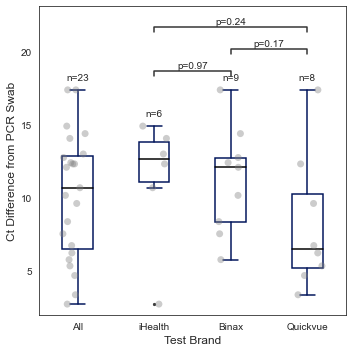

In [17]:
plt.figure(figsize=[5,5])

order = ['All','iHealth','Binax','Quickvue']
df=pd.melt(df_total_Cq[order])
ax = sns.boxplot(x="variable", y="value", order=order,data=df, **args_boxplot)
sns.stripplot(data=pd.melt(df_total_Cq[order]), x="variable", y="value", **args_stripplot)
add_n_XX(df,'variable','value',order,ax,offset=-.65,max=True)

print('Mean of all strips\' difference:', df_total_Cq.All.mean(),'\n')

pairs = [['iHealth','Binax'],['iHealth','Quickvue'],['Binax','Quickvue']]
annotator = Annotator(ax, pairs,data=pd.melt(df_total_Cq),x='variable',y='value',order=order)
#annotator.set_pvalues(get_pvalues2(df.dropna(),pairs))
pvalues = get_pvalues2(df.dropna(),pairs)
annotator.set_custom_annotations([f'p={p:.2g}' for p in pvalues])
annotator.annotate()

df_wilcoxon = save_wilcoxon_variances('Ct Difference from PCR', df, pairs, df_wilcoxon)

plt.xlabel("Test Brand", fontweight='normal', fontsize=12)
plt.ylabel("Ct Difference from PCR Swab", fontweight='normal', fontsize=12) 
plt.yticks(np.arange(5,25,5))
ax.get_legend().remove();
save_figure('fig/CT_difference_from_PCR.svg')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

First vs. Second: p=0.26


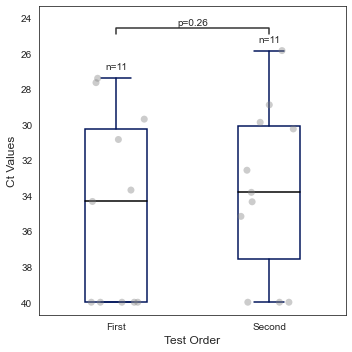

In [18]:
plt.figure(figsize=[5,5])

ax = sns.boxplot(x="variable", y="value", data=df_order,**args_boxplot)
sns.stripplot(data=df_order, x="variable", y="value",**args_stripplot)
add_n_XX(df_order,'variable','value',order=['First','Second'],ax=ax,offset=.5)

ax.invert_yaxis()

pairs = df_order.variable.unique()
annotator = Annotator(ax, [pairs],data=df_order,x='variable',y='value')
#annotator.set_pvalues([ranksums(first,second,nan_policy='omit').pvalue])
#annotator.set_pvalues(get_pvalues2(df_order, [pairs],wilcoxon=True))
pvalues = get_pvalues2(df_order, [pairs],wilcoxon=True)
annotator.set_custom_annotations([f'p={p:.2g}' for p in pvalues])
annotator.annotate()
df_wilcoxon = save_wilcoxon_variances('Test Order', df_order, [pairs], df_wilcoxon)

plt.xlabel("Test Order", fontweight='normal', fontsize=12)
plt.ylabel("Ct Values", fontweight='normal', fontsize=12) 
plt.legend([],[], frameon=False)

save_figure('fig/CT_test_order.svg')

##  Statistics for genome comparisons

In [82]:
# return relevant statistics in terms of how many samples had Cts, complete genomes, etc

# update dataframes with columns that will enable groupby() analyses
rdt_value['Ct<40'] = [g<40 for g in rdt_value.Cq]
genome_data_1['Ct<40'] = [g<40 for g in genome_data_1.Cq]
genomes_no40 = genome_data_1[genome_data_1['Ct<40']]
genomes_no40['Percent>80'] = [g>.8 for g in genomes_no40.Percent]
genomes_no40['Percent>10'] = [g>.10 for g in genomes_no40.Percent]

# calculate the various stats we want
genome_stats = pd.DataFrame({# Number & percent of samples with viral material, & total samples
                            'NumberPositive':rdt_value.groupby('variable').sum()['Ct<40'],\
                            'NumberSamples':rdt_value.groupby('variable').count()['Cq'],\
                            # Ct range of positive samples, and mean
                            'MinCt':rdt_value.groupby('variable').min()['Cq'],\
                            'MaxCt':rdt_value[rdt_value.Cq<40].groupby('variable').max()['Cq'],\
                            'MeanCt':rdt_value[rdt_value.Cq<40].groupby('variable').mean()['Cq'],\
                            'SDCt':rdt_value[rdt_value.Cq<40].groupby('variable').std()['Cq'],\
                            # Number of sequenced samples; number & percent of samples with complete genomes
                            'NumberSequenced':genomes_no40.groupby('variable').count()['Cq'],\
                            'NumberComplete':genomes_no40.groupby('variable').sum()['Percent>80'],\
                            'PercentComplete':genomes_no40.groupby('variable').mean()['Percent>80'],\
                            'NumPartial':genomes_no40.groupby('variable').sum()['Percent>10'],\
                            # Average percent of genome covered, for positive samples
                            'AveragePercent':genomes_no40.groupby('variable').mean()['Percent'],\
                            'SDPercent':genomes_no40.groupby('variable').std()['Percent'],\
                            # Average depth, for positive samples
                            'AverageDepth':genomes_no40.groupby('variable').mean()['assembly_mean_coverage'],\
                            'SDDepth':genomes_no40.groupby('variable').std()['assembly_mean_coverage']})
genome_stats['PercentWithCt'] = genome_stats['NumberPositive'] / genome_stats['NumberSamples'] * 100
# update any percent stats to be from 0-100 instead of 0-1
for percent in ['PercentComplete','AveragePercent','SDPercent']:
    genome_stats[percent] = (genome_stats[percent]*100)
# round all numbers to have only one decimal point
genome_stats = genome_stats.round(decimals=1)

In [84]:
tmp = genome_stats.reindex(['PCR Swab','Binax Strip','Binax Swab','Quickvue Strip','Quickvue Tube','iHealth'])
tmp[['NumberSamples','NumberPositive','PercentWithCt','MeanCt','MinCt','MaxCt','SDCt','NumberSequenced',\
     'AveragePercent','SDPercent','NumPartial','NumberComplete','AverageDepth','SDDepth']]

,NumberSamples,NumberPositive,PercentWithCt,MeanCt,MinCt,MaxCt,SDCt,NumberSequenced,AveragePercent,SDPercent,NumPartial,NumberComplete,AverageDepth,SDDepth
variable,,,,,,,,,,,,,,
PCR Swab,13,13,100.0,23.7,17.8,31.7,4.5,13,97.2,3.4,13,13,18463.2,14316.5
Binax Strip,9,5,55.6,30.3,27.6,33.8,2.2,2,22.8,32.2,1,0,44259.2,62592.0
Binax Swab,9,8,88.9,26.0,19.5,33.0,5.0,7,66.9,37.9,6,3,18257.6,15076.0
Quickvue Strip,8,6,75.0,29.6,25.8,35.2,3.2,5,66.0,38.3,4,2,21249.5,16974.6
Quickvue Tube,6,2,33.3,32.2,31.2,33.3,1.5,1,93.0,NaN,1,1,5006.7,NaN
iHealth,6,5,83.3,33.2,30.8,34.3,1.5,3,43.6,31.9,2,0,7487.0,7658.4


In [21]:
# for which samples could clade/lineage be accurately predicted by RDTs without PCR swab?
lineages = pd.DataFrame(index=genomes_no40.ID.unique(), \
                        columns=['R_clade','R_pango','Str_clade','Str_pango','Clade','Pango'])
for i in lineages.index:
    lineages['R_clade'].loc[i] = genomes_no40[genomes_no40.Sample==(i+"_R")].nextclade_clade.values[0]
    lineages['R_pango'].loc[i] = genomes_no40[genomes_no40.Sample==(i+"_R")].pango_lineage.values[0]
    lineages['Str_clade'].loc[i] = genomes_no40[genomes_no40.Sample.str.contains(pat=i+'_.*[^R]')].nextclade_clade.values
    lineages['Str_pango'].loc[i] = genomes_no40[genomes_no40.Sample.str.contains(pat=i+'_.*[^R]')].pango_lineage.values
    lineages['Clade'].loc[i] = lineages.R_clade[i] in lineages.Str_clade[i] 
    lineages['Pango'].loc[i] = lineages.R_pango[i] in lineages.Str_pango[i] 

display(lineages)
print(lineages[['Clade','Pango']].sum())
print(lineages[['Clade','Pango']].sum()/13)

,R_clade,R_pango,Str_clade,Str_pango,Clade,Pango
01,22B,BA.5.2.1,"[22B, 22B]","[Unassigned, Unassigned]",True,False
04,22D,BA.2.75.2,[22D],[Unassigned],True,False
05,22B,BF.21,[],[],False,False
06,22B,BF.27,[22B],[BF.27],True,True
07,22B,BA.5.2.1,"[22B, recombinant]","[BA.5.2.1, Unassigned]",True,True
08,22A,BA.4.6,[22A],[BA.4.6],True,True
09,22B,BA.5.2,"[nan, recombinant, recombinant]","[nan, Unassigned, Unassigned]",False,False
10,22B,BE.1.1,"[22B, 22B, 22B]","[Unassigned, BE.1.1, Unassigned]",True,True
11,22B,BE.1.1,[],[],False,False
12,22B,BF.26,[22B],[BF.26],True,True


Clade    10
Pango     7
dtype: object
Clade    0.769231
Pango    0.538462
dtype: object


In [22]:
# Above analysis but for each individual strip
df = genomes_no40.set_index(genomes_no40.Sample)

for pattern in ['_iH','Q.*_str','Q.*_tube','B.*_str', 'B.*_swab']:
    strip = df[df.Sample.str.contains(pat=pattern)].Sample.values
    swab = [i[0:2]+"_R" for i in strip]
    df.loc[[s for s in df.Sample if (s in strip) or (s in swab)]][['nextclade_clade', 'pango_lineage']]
    df1 = df.loc[[s for s in df.Sample if s in strip]][['nextclade_clade', 'pango_lineage']].reset_index(drop=True)
    df2 = df.loc[[s for s in df.Sample if s in swab]][['nextclade_clade', 'pango_lineage']].reset_index(drop=True)
    print(pattern, '\n', (df1 == df2).sum(),'total:',len(df1),'\n')

_iH 
 nextclade_clade    2
pango_lineage      0
dtype: int64 total: 3 

Q.*_str 
 nextclade_clade    4
pango_lineage      3
dtype: int64 total: 5 

Q.*_tube 
 nextclade_clade    1
pango_lineage      1
dtype: int64 total: 1 

B.*_str 
 nextclade_clade    1
pango_lineage      0
dtype: int64 total: 2 

B.*_swab 
 nextclade_clade    6
pango_lineage      4
dtype: int64 total: 7 



In [23]:
# Above analysis for iHealth strip only
lineages = pd.DataFrame(index=genomes_no40.ID.unique(), \
                        columns=['R_clade','R_pango','Str_clade','Str_pango','Clade','Pango'])
for i in lineages.index:
    lineages['R_clade'].loc[i] = genomes_no40[genomes_no40.Sample==(i+"_R")].nextclade_clade.values[0]
    lineages['R_pango'].loc[i] = genomes_no40[genomes_no40.Sample==(i+"_R")].pango_lineage.values[0]
    lineages['Str_clade'].loc[i] = genomes_no40[genomes_no40.Sample.str.contains(pat=i+'_.*[^R]')].nextclade_clade.values
    lineages['Str_pango'].loc[i] = genomes_no40[genomes_no40.Sample.str.contains(pat=i+'_.*[^R]')].pango_lineage.values
    lineages['Clade'].loc[i] = lineages.R_clade[i] in lineages.Str_clade[i] 
    lineages['Pango'].loc[i] = lineages.R_pango[i] in lineages.Str_pango[i] 

display(lineages)
print(lineages[['Clade','Pango']].sum())
print(lineages[['Clade','Pango']].sum()/13)

,R_clade,R_pango,Str_clade,Str_pango,Clade,Pango
01,22B,BA.5.2.1,"[22B, 22B]","[Unassigned, Unassigned]",True,False
04,22D,BA.2.75.2,[22D],[Unassigned],True,False
05,22B,BF.21,[],[],False,False
06,22B,BF.27,[22B],[BF.27],True,True
07,22B,BA.5.2.1,"[22B, recombinant]","[BA.5.2.1, Unassigned]",True,True
08,22A,BA.4.6,[22A],[BA.4.6],True,True
09,22B,BA.5.2,"[nan, recombinant, recombinant]","[nan, Unassigned, Unassigned]",False,False
10,22B,BE.1.1,"[22B, 22B, 22B]","[Unassigned, BE.1.1, Unassigned]",True,True
11,22B,BE.1.1,[],[],False,False
12,22B,BF.26,[22B],[BF.26],True,True


Clade    10
Pango     7
dtype: object
Clade    0.769231
Pango    0.538462
dtype: object


In [24]:
genomes_no40[['Sample','nextclade_clade','pango_lineage']]

,Sample,nextclade_clade,pango_lineage
0,01_B1_swab,22B,Unassigned
1,01_Q2_str,22B,Unassigned
2,01_R,22B,BA.5.2.1
3,04_B2_swab,22D,Unassigned
4,04_R,22D,BA.2.75.2
5,05_R,22B,BF.21
6,06_Q2_tube,22B,BF.27
7,06_R,22B,BF.27
8,07_B2_swab,22B,BA.5.2.1
9,07_Q1_str,recombinant,Unassigned


## Gender and age distributions

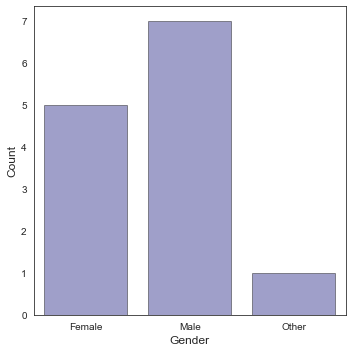

In [25]:
## Gender and age demographics
plt.figure(figsize=[5,5])

sns.set_style("white") 
gender_dist = sns.countplot(x=seq_metadata['What is your gender?'],color='darkblue', alpha=0.4,edgecolor='black')

plt.xlabel("Gender", fontweight='normal', fontsize=12)
plt.ylabel("Count", fontweight='normal', fontsize=12)

save_figure('fig/cohort1_gender.svg')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


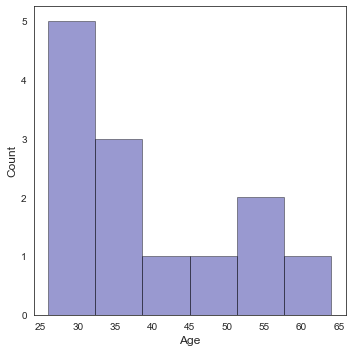

In [26]:
plt.figure(figsize=[5,5])

age_dist = sns.distplot(x=seq_metadata['What is your age in years?'], hist=True, kde=False, 
             bins=int(30/5), color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Age", fontweight='normal', fontsize=12)
plt.ylabel("Count", fontweight='normal', fontsize=12)

save_figure('fig/cohort1_age.svg')

## iSNV analyses comparing RDTs and PCRs

In [27]:
# function to remove / mask known sites that are unreliable per ampseq methods
prob_sites = allel.vcf_to_dataframe('problematic_sites_sarsCov2.vcf',fields=['POS','FILTER'])
def masked_vcf(filename):
    df = allel.vcf_to_dataframe(filename, fields=['POS','ALT','AF','SB'])
    if df is None:
        return df
    problematic_sites = list(prob_sites.POS[prob_sites.FILTER_mask==True].values)
    problematic_sites.append(28370)
    problematic_sites.append(28371)
    return df[[i not in problematic_sites for i in df.POS]].reset_index(drop=True)

# function to add columns to mark sites as 1) SNV (>50%) v. iSNV (<50%) & 2) >0 strand bias or AF<3%
def mark_sites(df):
    df['SNV'] = np.array(df.AF_1>=.5)
    df['exclude'] = np.array(df.AF_1<.03) | np.array(df.SB>0)
    return df

# return dataframe for individual coverage plot (txt file); only return locations with DP>0 (or other value)
def cleaned_cov(filename, DP=100):
    df = pd.read_csv(filename, sep='\t', header=None, names=['Ref','POS','DP'])
    return df[df.DP>DP].reset_index(drop=True)

# return counts of SNVs (or iSNVs) in following order, for a given set of PCR v. RDT comparison:
# 0: number of (i)SNVs to include for PCR swab
# 1: number of (i)SNVs to exclude for PCR swab
# 2: number of (i)SNVs in RDT that are concordant with PCR
# 3: number of (i)SNVs in RDT that were discordant with PCR
# 4: number of (i)SNVs in RDT to exclude for RDT
def SNV_counts(df_PCR_lim, df_RDT_lim, iSNV=False):
    to_return = np.zeros(5)
    # limit to either SNVs or iSNVs
    if iSNV==False:
        df_PCR_lim = df_PCR_lim[df_PCR_lim.SNV == True]
        df_RDT_lim = df_RDT_lim[df_RDT_lim.SNV == True]
    else:
        # check first if any iSNVs are consensus-level in the other...
        for i in range(len(df_PCR_lim)):
            if ~df_PCR_lim.exclude[i]: # included in analysis...
                if df_PCR_lim.SNV[i] == False: # and is iSNV...
                    if df_PCR_lim.POS[i] in df_RDT_lim.POS.values: # and POS is in both...
                        print(df_PCR_lim.POS[i])
                    
        df_PCR_lim = df_PCR_lim[df_PCR_lim.SNV == False]
        df_RDT_lim = df_RDT_lim[df_RDT_lim.SNV == False]
    
    # pull out PCR numbers
    to_return[0] = sum(~df_PCR_lim.exclude) # 0: number of (i)SNVs to include for PCR swab
    to_return[1] = sum(df_PCR_lim.exclude) # 1: number of (i)SNVs to exclude for PCR swab
    to_return[4] = sum(df_RDT_lim.exclude) # 4: number of (i)SNVs in RDT to exclude for RDT
    df_RDT_lim = df_RDT_lim[~df_RDT_lim.exclude].reset_index(drop=True)
    df_PCR_lim = df_PCR_lim[~df_PCR_lim.exclude].reset_index(drop=True)
    SNVs_PCR = set([str(df_PCR_lim.POS[a])+df_PCR_lim.ALT_1[a] for a in range(len(df_PCR_lim))])
    SNVs_RDT = set([str(df_RDT_lim.POS[a])+df_RDT_lim.ALT_1[a] for a in range(len(df_RDT_lim))])
    to_return[2] = len(SNVs_PCR & SNVs_RDT) # 2: number of (i)SNVs in RDT that are concordant with PCR
    to_return[3] = len(SNVs_RDT) - to_return[2] # 3: number of (i)SNVs in RDT that were discordant with PCR
    
    return to_return

In [28]:
# curate all vcf files, all coverage_plot.txt files (dataframe with filename, Sample name, patient ID)
vcf_files, cov_files = pd.DataFrame(), pd.DataFrame()
vcf_files['filename'] = !ls ../vcf/*.vcf
cov_files['filename'] = !ls ../covplot/*.txt

for i, df in enumerate([vcf_files, cov_files]): # add in columns for Sample name & patient ID
    df['Sample'] = [i[2].split('.')[0].replace('strip','str') for i in df.filename.str.split('/')]
    df['ID'] = [s[0:2] for s in df.Sample]
    
# limit to files that were actually sequenced, and that have more than one sample per individual; cohort #1 only
vcf_files = vcf_files[[s in list(genome_data_1[genome_data_1.Percent>0].Sample) for s in vcf_files.Sample]]
cov_files = cov_files[[s in list(genome_data_1[genome_data_1.Percent>0].Sample) for s in cov_files.Sample]]
vcf_files = vcf_files[[ID not in vcf_files.ID.unique()[vcf_files.groupby('ID').count()['Sample']==1] \
         for ID in vcf_files.ID]].reset_index(drop=True)
cov_files = cov_files[[ID not in cov_files.ID.unique()[cov_files.groupby('ID').count()['Sample']==1] \
         for ID in cov_files.ID]].reset_index(drop=True)

In [29]:
# initialize dataframe in which counts of SNVs will be stored
df_counts = pd.DataFrame(columns=['PCR_include','PCR_exclude',\
                               'RDT_concord','RDT_discord','RDT_exclude'],\
                         index = ['SNV_RDT_tube','iSNV_RDT_tube',\
                                 'SNV_RDT_strip','iSNV_RDT_strip',\
                                 'SNV_RDT_swab','iSNV_RDT_swab'],\
                         data=0)

# cycle through all PCR v. RDT comparisons, pausing on each PCR and comparing it to its corresponding RDTs
# start by pulling out each PCR sample
for _, row in vcf_files[vcf_files.filename.str.contains('_R')].iterrows():
    f, Sample_PCR, ID = row
    df_PCR = masked_vcf(f) # process PCR vcf file, while masking unreliable sites
    df_PCR = mark_sites(df_PCR) # mark sites as SNV (>50%) v. iSNV (<50%); also as >0 SB or AF <3%
    cov_PCR = cleaned_cov(cov_files[cov_files.Sample==Sample_PCR].filename.values[0]) # coverage plot
    
    # for loop to cycle through comparing the above PCR file to corresponding RDT files:
    for _, row in vcf_files[vcf_files.ID==ID].iterrows():    
        # repeat same process above from PCR for RDT
        rdt, Sample, _ = row
        if Sample != Sample_PCR:
            df_RDT = masked_vcf(rdt)
            if df_RDT is not None:
                df_RDT = mark_sites(df_RDT) 
                cov_RDT = cleaned_cov(cov_files[cov_files.Sample==Sample].filename.values[0])

                # what component of RDT? 0=buffer/tube, 1=strip, 2=swab
                RDT_comp = ('s' in Sample)*1 + ('i' in Sample)*1 + ('w' in Sample)*1

                # use coverage_plot.txt to limit analysis to regions of shared coverage
                shared = set(cov_PCR.POS) & set(cov_RDT.POS)
                df_PCR_lim = df_PCR[df_PCR.POS.isin(shared)].reset_index(drop=True)
                df_RDT_lim = df_RDT[df_RDT.POS.isin(shared)].reset_index(drop=True)
                
                # also drop if it's dropped due to SB in the other one...
                for i in range(len(df_PCR_lim)):
                    if df_PCR_lim.SB[i]>0:
                        if df_PCR_lim.POS[i] in df_RDT_lim.POS.values:
                            df_RDT_lim.loc[df_RDT_lim.POS==df_PCR_lim.POS[i],'exclude']=True

                for i in range(len(df_RDT_lim)):
                    if df_RDT_lim.SB[i]>0:
                        if df_RDT_lim.POS[i] in df_PCR_lim.POS.values:
                            df_PCR_lim.loc[df_PCR_lim.POS==df_RDT_lim.POS[i],'exclude']=True

                # add counts to df_counts dataframe, in appropriate positions
                df_counts.iloc[RDT_comp*2] += SNV_counts(df_PCR_lim, df_RDT_lim, iSNV=False)
                df_counts.iloc[RDT_comp*2+1] += SNV_counts(df_PCR_lim, df_RDT_lim, iSNV=True)

5950


Text(0.5, 1.0, 'SNVs')

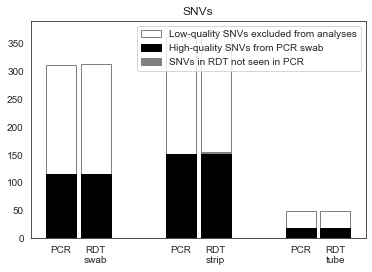

In [30]:
width, space = .25, .02

for i,label in enumerate(['SNV_RDT_swab','SNV_RDT_strip','SNV_RDT_tube']):
    plt.bar(i-width/2-space,df_counts.PCR_include[label]+df_counts.PCR_exclude[label],\
            color='white',edgecolor='gray',width=width,label='Low-quality SNVs excluded from analyses')
    plt.bar(i-width/2-space,df_counts.PCR_include[label],\
            color='k',edgecolor='k',width=width,label='High-quality SNVs from PCR swab')
    plt.bar(i+width/2+space,df_counts.RDT_concord[label]+df_counts.RDT_discord[label]+\
            df_counts.RDT_exclude[label],\
           color='white',edgecolor='gray',width=width)
    plt.bar(i+width/2+space,df_counts.RDT_concord[label]+df_counts.RDT_discord[label],\
           color='gray',edgecolor='gray',width=width,label='SNVs in RDT not seen in PCR')
    plt.bar(i+width/2+space,df_counts.RDT_concord[label],\
           color='k',edgecolor='k',width=width)

plt.xticks(ticks=[0-width/2-space,0+width/2+space,1-width/2-space,\
                  1+width/2+space,2-width/2-space,2+width/2+space],\
           labels=['PCR','RDT\nswab','PCR','RDT\nstrip','PCR','RDT\ntube']);
h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:3], l[0:3])
plt.title('SNVs')

Text(0.5, 1.0, 'iSNVs')

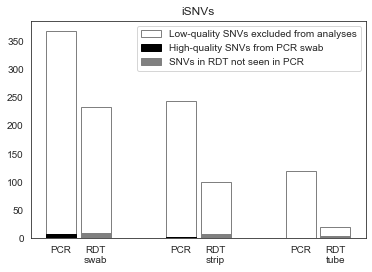

In [31]:
width, space = .25, .02

for i,label in enumerate(['iSNV_RDT_swab','iSNV_RDT_strip','iSNV_RDT_tube']):
    plt.bar(i-width/2-space,df_counts.PCR_include[label]+df_counts.PCR_exclude[label],\
            color='white',edgecolor='gray',width=width,label='Low-quality SNVs excluded from analyses')
    plt.bar(i-width/2-space,df_counts.PCR_include[label],\
            color='k',edgecolor='k',width=width,label='High-quality SNVs from PCR swab')
    plt.bar(i+width/2+space,df_counts.RDT_concord[label]+df_counts.RDT_discord[label]+\
            df_counts.RDT_exclude[label],\
           color='white',edgecolor='gray',width=width)
    plt.bar(i+width/2+space,df_counts.RDT_concord[label]+df_counts.RDT_discord[label],\
           color='gray',edgecolor='gray',width=width,label='SNVs in RDT not seen in PCR')
    plt.bar(i+width/2+space,df_counts.RDT_concord[label],\
           color='k',edgecolor='k',width=width)

plt.xticks(ticks=[0-width/2-space,0+width/2+space,1-width/2-space,\
                  1+width/2+space,2-width/2-space,2+width/2+space],\
           labels=['PCR','RDT\nswab','PCR','RDT\nstrip','PCR','RDT\ntube']);

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:3], l[0:3])
plt.title('iSNVs')

In [32]:
df_pretty = df_counts.copy()
df_pretty = df_pretty.reindex(index=['SNV_RDT_swab','SNV_RDT_strip','SNV_RDT_tube',\
          'iSNV_RDT_swab','iSNV_RDT_strip','iSNV_RDT_tube'])
df_pretty = df_pretty[['PCR_include','RDT_concord','RDT_discord']]
df_pretty['Concordancy'] = df_pretty.RDT_concord/(df_pretty.PCR_include+df_pretty.RDT_discord)*100
df_pretty

,PCR_include,RDT_concord,RDT_discord,Concordancy
SNV_RDT_swab,115,115,0,100.000000
SNV_RDT_strip,151,151,4,97.419355
SNV_RDT_tube,19,19,0,100.000000
iSNV_RDT_swab,7,1,8,6.666667
iSNV_RDT_strip,3,0,7,0.000000
iSNV_RDT_tube,0,0,4,0.000000


# Cohort 2: MPHN2 senior housing outbreak

## Data tables

In [33]:
# Samples to keep (other samples were SARS-CoV-2 negative per rapid tests)
TOKEEP = [str(i) for i in [209,301,314,315,407,501,514,518,808,904]]

In [34]:
# clean up pcr data table
MPHN2 = MPHN2_pcr
MPHN2 = PCR_results(MPHN2).rename(columns={'Sample Name':'Sample','CT':'value'})
MPHN2['value'] = MPHN2['value'].replace('Undetermined', 40)

# add column for type & for ID
MPHN2['variable'] = pd.Series([i[-1] for i in MPHN2.Sample.str.split('_')]).str.capitalize()
MPHN2.loc[[t in [str(x) for x in range(6)] for t in MPHN2.variable],'variable'] = 'Water Control'
MPHN2.loc[MPHN2.variable=='Liquid','variable'] = 'Buffer'
MPHN2['ID'] = [MPHN2.Sample[i][0:3] if MPHN2.variable[i] in ['Swab','Buffer','Strip'] \
               else '' for i in range(len(MPHN2))]

# drop samples that were already known as SARS-CoV-2 negative
MPHN2 = MPHN2.drop([i for i in range(len(MPHN2)) if MPHN2.ID[i] not in TOKEEP]).reset_index(drop=True)

In [35]:
MPHN2[MPHN2.value==40]

,Sample,value,variable,ID
7,314_strip,40.0,Strip,314
28,904_strip,40.0,Strip,904


In [36]:
# clean up genomic data to have standard ID/sample name
genome_data_2 = genomes.rename(columns={'entity:sample_set_id':'Sample'}).copy()
genome_data_2['Sample'] = [item[0] for item in genome_data_2['Sample'].str.split('.')]
genome_data_2['ID'] = [s[0:3] for s in genome_data_2.Sample]

# add extra metrics
LENGTH = 29903
genome_data_2['value'] = genome_data_2['assembly_length_unambiguous']/LENGTH
genome_data_2['Percent>80'] = genome_data_2.value > .8

# merge with other dataframe to limit to appropriate samples
genome_data_2 = pd.merge(genome_data_2, MPHN2[['Sample','variable','value']].rename(columns={'value':'Cq'}),\
                       how='right', on='Sample')

## Genome stats

In [85]:
# return relevant statistics in terms of how many samples had Cts, complete genomes, etc

# update dataframes with columns that will enable groupby() analyses
genome_data_2['Ct<40'] = [g<40 for g in genome_data_2.Cq]
genomes_no40 = genome_data_2[genome_data_2['Ct<40']]
genomes_no40['Percent>80'] = [g>.8 for g in genomes_no40.value]
genomes_no40['Percent>10'] = [g>.1 for g in genomes_no40.value]

# calculate the various stats we want
genome_stats = pd.DataFrame({# Number & percent of samples with viral material, & total samples
                            'NumberPositive':genome_data_2.groupby('variable').sum()['Ct<40'],\
                            'NumberSamples':genome_data_2.groupby('variable').count()['Cq'],\
                            'PercentWithCt':genome_data_2.groupby('variable').mean()['Ct<40'],\
                            # Ct range of positive samples, and mean
                            'MinCt':genomes_no40.groupby('variable').min()['Cq'],\
                            'MaxCt':genomes_no40.groupby('variable').max()['Cq'],\
                            'MeanCt':genomes_no40.groupby('variable').mean()['Cq'],\
                            'SDCt':genomes_no40.groupby('variable').std()['Cq'],\
                            # Number & percent of positive samples with complete genomes; & number sequenced
                            'NumberSequenced':genomes_no40.groupby('variable').count()['Cq'],\
                            'NumberComplete':genomes_no40.groupby('variable').sum()['Percent>80'],\
                            'PercentComplete':genomes_no40.groupby('variable').mean()['Percent>80'],\
                            'NumPartial':genomes_no40.groupby('variable').sum()['Percent>10'],\
                            # Average percent of genome covered, for positive samples
                            'AveragePercent':genomes_no40.groupby('variable').mean()['value'],\
                            'SDPercent':genomes_no40.groupby('variable').std()['value'],\
                            # Average depth, for positive samples
                            'AverageDepth':genomes_no40.groupby('variable').mean()['assembly_mean_coverage'],\
                            'SDDepth':genomes_no40.groupby('variable').std()['assembly_mean_coverage']})

# update any percent stats to be from 0-100 instead of 0-1
for percent in ['PercentWithCt','PercentComplete','AveragePercent','SDPercent']:
    genome_stats[percent] = (genome_stats[percent]*100)
# round all numbers to have only one decimal point
genome_stats = genome_stats.round(decimals=1)

<ipython-input-85-2eeb8f8859e1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genomes_no40['Percent>80'] = [g>.8 for g in genomes_no40.value]
<ipython-input-85-2eeb8f8859e1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genomes_no40['Percent>10'] = [g>.1 for g in genomes_no40.value]
<ipython-input-85-2eeb8f8859e1>:15: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be v

In [86]:
tmp = genome_stats.loc[['Strip','Swab','Buffer']]
tmp[['NumberSamples','NumberPositive','PercentWithCt','MeanCt','MinCt','MaxCt','SDCt','NumberSequenced',\
     'AveragePercent','SDPercent','NumPartial','NumberComplete','AverageDepth','SDDepth']]

,NumberSamples,NumberPositive,PercentWithCt,MeanCt,MinCt,MaxCt,SDCt,NumberSequenced,AveragePercent,SDPercent,NumPartial,NumberComplete,AverageDepth,SDDepth
variable,,,,,,,,,,,,,,
Strip,10,8,80.0,33.0,30.8,35.2,1.2,8,42.6,31.0,6,1,5677.2,8489.2
Swab,10,10,100.0,27.6,20.2,34.2,3.8,10,95.1,8.5,10,9,17902.3,15637.3
Buffer,10,10,100.0,32.5,28.7,35.2,2.1,10,59.4,34.3,9,3,10437.7,12174.8


In [39]:
# for which samples could clade/lineage be accurately predicted by RDTs without PCR swab? -- for strip
lineages = pd.DataFrame(index=genome_data_2[[s in ['Buffer','Strip','Swab'] for s in genome_data_2.variable]].ID.unique(), \
                        columns=['R_clade','R_pango','Str_clade','Str_pango','Clade','Pango'])
for i in lineages.index:
    lineages['R_clade'].loc[i] = genome_data_2[genome_data_2.Sample==(i+"_swab")].nextclade_clade.values[0]
    lineages['R_pango'].loc[i] = genome_data_2[genome_data_2.Sample==(i+"_swab")].pango_lineage.values[0]
    lineages['Str_clade'].loc[i] = genome_data_2[genome_data_2.Sample.str.contains(pat=i+'_strip')].nextclade_clade.values
    lineages['Str_pango'].loc[i] = genome_data_2[genome_data_2.Sample.str.contains(pat=i+'_strip')].pango_lineage.values
    lineages['Clade'].loc[i] = lineages.R_clade[i] in lineages.Str_clade[i] 
    lineages['Pango'].loc[i] = lineages.R_pango[i] in lineages.Str_pango[i] 

display(lineages)
print(lineages[['Clade','Pango']].sum())
print(lineages[['Clade','Pango']].sum()/13)

,R_clade,R_pango,Str_clade,Str_pango,Clade,Pango
209,22E,EF.1.2,[22E],[Unassigned],True,False
301,23A,XBB.1.5,[22F],[Unassigned],False,False
314,22E,EF.1.2,[nan],[nan],False,False
315,23A,XBB.1.5,[23A],[XBB.1.5],True,True
407,23A,XBB.1.5,[recombinant],[Unassigned],False,False
501,23A,XBB.1.5,[23A],[Unassigned],True,False
514,23A,XBB.1.5,[22F],[Unassigned],False,False
518,23A,XBB.1.5,[recombinant],[Unassigned],False,False
808,23A,XBB.1.5,[22F],[Unassigned],False,False
904,23A,XBB.1.5,[nan],[Unassigned],False,False


Clade    3
Pango    1
dtype: object
Clade    0.230769
Pango    0.076923
dtype: object


In [40]:
# for which samples could clade/lineage be accurately predicted by RDTs without PCR swab? -- for tube
lineages = pd.DataFrame(index=genome_data_2[[s in ['Buffer','Strip','Swab'] for s in genome_data_2.variable]].ID.unique(), \
                        columns=['R_clade','R_pango','Str_clade','Str_pango','Clade','Pango'])
for i in lineages.index:
    lineages['R_clade'].loc[i] = genome_data_2[genome_data_2.Sample==(i+"_swab")].nextclade_clade.values[0]
    lineages['R_pango'].loc[i] = genome_data_2[genome_data_2.Sample==(i+"_swab")].pango_lineage.values[0]
    lineages['Str_clade'].loc[i] = genome_data_2[genome_data_2.Sample.str.contains(pat=i+'_liquid')].nextclade_clade.values
    lineages['Str_pango'].loc[i] = genome_data_2[genome_data_2.Sample.str.contains(pat=i+'_liquid')].pango_lineage.values
    lineages['Clade'].loc[i] = lineages.R_clade[i] in lineages.Str_clade[i] 
    lineages['Pango'].loc[i] = lineages.R_pango[i] in lineages.Str_pango[i] 

display(lineages)
print(lineages[['Clade','Pango']].sum())
print(lineages[['Clade','Pango']].sum()/13)

,R_clade,R_pango,Str_clade,Str_pango,Clade,Pango
209,22E,EF.1.2,[22E],[EF.1.2],True,True
301,23A,XBB.1.5,[23A],[Unassigned],True,False
314,22E,EF.1.2,[nan],[nan],False,False
315,23A,XBB.1.5,[23A],[XBB.1.5],True,True
407,23A,XBB.1.5,[22F],[Unassigned],False,False
501,23A,XBB.1.5,[23A],[XBB.1.5],True,True
514,23A,XBB.1.5,[23A],[XBB.1.5],True,True
518,23A,XBB.1.5,[23A],[Unassigned],True,False
808,23A,XBB.1.5,[recombinant],[Unassigned],False,False
904,23A,XBB.1.5,[22F],[Unassigned],False,False


Clade    6
Pango    4
dtype: object
Clade    0.461538
Pango    0.307692
dtype: object


In [41]:
genomes_no40[['Sample','nextclade_clade','pango_lineage']]

,Sample,nextclade_clade,pango_lineage
0,209_liquid,22E,EF.1.2
1,209_strip,22E,Unassigned
2,209_swab,22E,EF.1.2
3,301_liquid,23A,Unassigned
4,301_strip,22F,Unassigned
5,301_swab,23A,XBB.1.5
6,314_liquid,NaN,NaN
8,314_swab,22E,EF.1.2
9,315_liquid,23A,XBB.1.5
10,315_strip,23A,XBB.1.5


# Both cohorts

## Relevant dataframes 

Create rdt dataframe with a few extra columns, to merge in eventually

In [42]:
rdt_new = rdt_value.copy().rename(columns={'Cq':'value'}).reset_index(drop=True)
rdt_new['Brand'] = [a[1][0] for a in rdt_new['Sample'].str.split('_')]
rdt_new['Component'] = [a[2] if len(a)==3 else np.nan for a in rdt_new['Sample'].str.split('_')]
rdt_new['variable'] = [rdt_new.loc[a,'Brand'] + str(rdt_new.loc[a,'Component']) for a in range(len(rdt_new))]

Combine MPHN2 and rdt_new to have all samples together in one dataframe

In [43]:
combined = MPHN2.append(rdt_new[['Sample','value','variable','ID']]).reset_index(drop=True)

# now let's combine with genome length
all_genome = genome_data_1.append(genome_data_2.rename(columns={'value':'Percent'}))
all_genome = all_genome[['Sample','ID','assembly_length_unambiguous','Percent','pango_lineage']]
combined = pd.merge(combined,all_genome,how='left',on=['Sample','ID'])

# create categories to distinguish between cohorts and component (for now, just need cohort 1 strip)
combined['category'] = np.nan
combined.loc[combined.variable=='inan','category'] = 'Strip'
combined.loc[combined.variable=='Bstr','category'] = 'Strip'
combined.loc[combined.variable=='Qstr','category'] = 'Strip'

Comparisons of Ct difference for matched pairs: PCR v. RDT strip / swab; RDT strip v. swab / tube

In [44]:
# PCR v. RDT strip: for all cohort 1 strips (i.e. category=='Strip')
PCR_minus_RDTstr = [combined[combined.Sample == combined.ID[i]+'_R'].value.values[0] - combined.value[i] \
                    for i in combined[combined.category=='Strip'].index]
# PCR v. RDT swab: for cohort 1 Binax swabs
PCR_minus_RDTswab = [combined[combined.Sample == combined.ID[i]+'_R'].value.values[0] - combined.value[i] \
                    for i in combined[combined.variable=='Bswab'].index]
# RDT strip v. swab: first for cohort 1 BinaxNOW matched samples
RDTswab_minus_RDTstr = [combined[combined.Sample.str.contains(combined.ID[i]+'_B.*swab')].value.values[0] - \
                        combined.value[i] for i in combined[combined.variable=='Bstr'].index \
                       if len(combined[combined.Sample.str.contains(combined.ID[i]+'_B.*swab')])]
# second for cohort 2 iHealth matched samples
RDTswab_minus_RDTstr.extend([combined[combined.Sample.str.contains(combined.ID[i]+'_swab')].value.values[0] - \
                             combined.value[i] for i in combined[combined.variable=='Strip'].index])
# RDT strip v. tube: first for cohort 1 Quickvue matched samples
RDTtube_minus_RDTstr = [combined[combined.Sample.str.contains(combined.ID[i]+'_Q.*tube')].value.values[0] - \
                        combined.value[i] for i in combined[combined.variable=='Qstr'].index \
                        if len(combined[combined.Sample.str.contains(combined.ID[i]+'_Q.*tube')])]
# second for cohort 2 iHealth matched samples
RDTtube_minus_RDTstr.extend([combined[combined.Sample.str.contains(combined.ID[i]+'_liquid')].value.values[0] - \
                             combined.value[i] for i in combined[combined.variable=='Strip'].index])

d = {'PCR_minus_RDTstr':PCR_minus_RDTstr,'PCR_minus_RDTswab':PCR_minus_RDTswab,\
     'RDTswab_minus_RDTstr':RDTswab_minus_RDTstr,'RDTtube_minus_RDTstr':RDTtube_minus_RDTstr}
Ctdiffs = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))

Comparisons of genome length difference for matched pairs: PCR v. each strip brand&component

In [45]:
d = {}
for comp in ['Bswab','Bstr','Qtube','Qstr','inan']:
    d[comp] = [combined.Percent[i] - combined[combined.Sample==combined.ID[i]+'_R'].Percent.values[0] \
               for i in combined[combined.variable==comp].index]

Genome_diffs = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))

Comparisons of genome length difference for matched pairs: PCR v. each RDT component

In [46]:
d = {'Strip':[]}
for comp in ['Bswab','Bstr','Qtube','Qstr','inan']: #strip
    d['Strip'].extend([combined.Percent[i] - combined[combined.Sample==combined.ID[i]+'_R'].Percent.values[0] \
               for i in combined[combined.variable==comp].index])
d['Buffer'] = [combined.Percent[i] - combined[combined.Sample==combined.ID[i]+'_R'].Percent.values[0] \
               for i in combined[combined.variable=='Qtube'].index]
d['Swab'] = [combined.Percent[i] - combined[combined.Sample==combined.ID[i]+'_R'].Percent.values[0] \
               for i in combined[combined.variable=='Bswab'].index]

Genome_diffs2 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))

## Figures 

In [47]:
sns.set_style('white')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Bswab vs. Bstr: p=0.012
Buffer vs. Strip: p=0.014
Swab vs. Buffer: p=0.002
Qstr vs. Qtube: p=0.068
Swab vs. Strip: p=0.002
Diff for iHealth strip & buffer: 1.89555


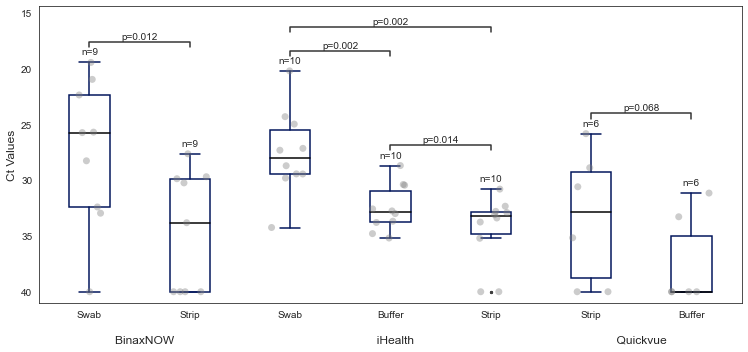

In [48]:
# update dataframe to only include matched sets for Qstr & Qtube; Bswab & Bstr (cohort2 is already matched)
df = combined.copy()
for i in range(len(combined)):
    for text in ['Q','Bs']: # check for matched Qstr & Qtube, then Bstr & Bswab sets
        if text in df.loc[i].variable:
            if sum([text in x for x in df[df.ID==df.loc[i].ID].variable]) < 2:
                df.drop([i], inplace=True)
            break # no need to check same location for other type of RDT
order = ['Bswab', 'Bstr', 'Swab','Buffer','Strip','Qstr','Qtube']
labels = ['Swab','Strip','Swab','Buffer','Strip','Strip','Buffer']

f = plt.figure(figsize=[10.5,5])
ax = sns.stripplot(data=df, x="variable", y="value", order=order, **args_stripplot)
sns.boxplot(x="variable", y="value", data=df, order=order, **args_boxplot)

ax.invert_yaxis()

pairs = [['Bstr','Bswab'],['Buffer','Strip'],['Buffer','Swab'],['Swab','Strip'],['Qstr','Qtube']]
annotator = Annotator(ax, pairs,order=order,data=df,x='variable',y='value')
#annotator.set_pvalues(get_pvalues2(df,pairs,wilcoxon=True)) # do wilcoxon paired test
pvalues = get_pvalues2(df,pairs,wilcoxon=True)
annotator.set_custom_annotations([f'p={p:.2g}' for p in pvalues])
annotator.annotate()
#df_wilcoxon = save_wilcoxon_variances('Ct Values', df, pairs, df_wilcoxon)

lspace, rspace=[60,60]
ax.set_xlabel('\nBinaxNOW'+lspace*' '+'iHealth'+rspace*' '+'Quickvue', fontsize=12)
ax.set_xticklabels(labels)
ax.set_ylabel('Ct Values', fontsize=12)
ax.get_legend().remove()
print('Diff for iHealth strip & buffer:',
      df[df.variable=='Strip'].value.mean() - df[df.variable=='Buffer'].value.mean())

add_n_XX(df,'variable','value',order,ax,offset=.7)

save_figure('fig/CT_allbrands_allcomponents.svg')

In [49]:
Cts_buffer_strip = df[[v in ['Strip','Buffer'] for v in df.variable]].value.values
Cts_buffer = Cts_buffer_strip[np.arange(0,len(Cts_buffer_strip),2)]
Cts_strip = Cts_buffer_strip[np.arange(1,len(Cts_buffer_strip),2)]
print('mean difference:',np.mean(Cts_buffer-Cts_strip))
print('std:',np.std(Cts_buffer-Cts_strip))

mean difference: -1.8955499999999996
std: 1.9266354928994736


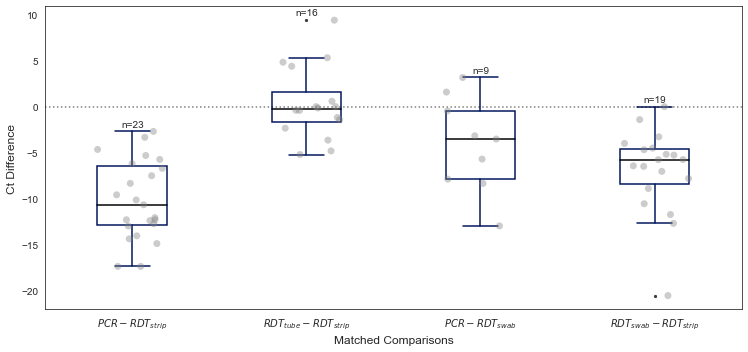

In [50]:
f = plt.figure(figsize=[10.5,5])

df = pd.melt(Ctdiffs)
order = ['PCR_minus_RDTstr','RDTtube_minus_RDTstr','PCR_minus_RDTswab','RDTswab_minus_RDTstr']
labels = ["$PCR - RDT_{strip}$",'$RDT_{tube} - RDT_{strip}$',\
          '$PCR - RDT_{swab}$','$RDT_{swab} - RDT_{strip}$']

ax = sns.stripplot(data=df, x="variable", y="value", order=order, **args_stripplot)
sns.boxplot(x="variable", y="value", order=order, data=df, **args_boxplot)
add_n_XX(df,'variable','value',order,ax,offset=-.5,max=True)

plt.plot(np.arange(-.5,4,.5),[0]*9,'k:',alpha=.5)

ax.set_ylabel('Ct Difference', fontsize=12)
ax.set_xticklabels(labels)
ax.set_xlabel('Matched Comparisons', fontsize=12)
ax.get_legend().remove()

save_figure('fig/CT_matched_comparisons.svg')

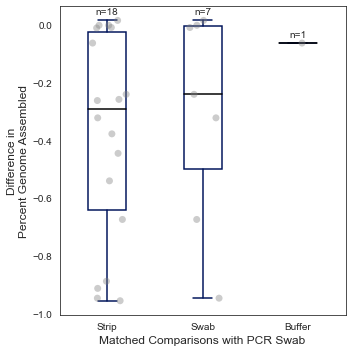

In [51]:
plt.figure(figsize=[5,5])

df = pd.melt(Genome_diffs2)
order = ['Strip','Swab','Buffer']

sns.boxplot(x="variable", y="value", order=order, data=df, **args_boxplot)
ax = sns.stripplot(data=df, x="variable", y="value", order=order, **args_stripplot)
add_n_XX(df,'variable','value',order,ax,offset=-.02,max=True)

ax.set_ylabel('Difference in\nPercent Genome Assembled', fontsize=12)
ax.set_xlabel('Matched Comparisons with PCR Swab', fontsize=12)
ax.get_legend().remove()

save_figure('fig/genomic_matched_comparisons.svg')

# samples Ct>32: 24
Spearman r^2: 0.6393824392270028 
Spearman p value: 1.0983644261318508e-14


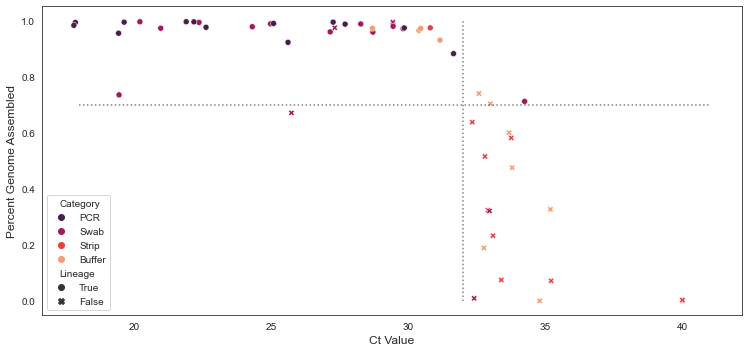

In [52]:
plt.figure(figsize=[10.5,5])

df = combined.copy().rename({'category':'Category'})
locs = np.where([len(i)==3 for i in df.ID])[0]
df.loc[locs,'Category'] = df.loc[locs,'variable']
df.loc[np.where(df.variable=='Bswab')[0],'Category'] = 'Swab'
df.loc[np.where(df.variable=='Qtube')[0],'Category'] = 'Buffer'
df.loc[np.where(df.variable=='Rnan')[0],'Category'] = 'PCR'
df['Lineage'] = ['B' in str(l) for l in combined.pango_lineage]

order = ['PCR','Swab','Strip','Buffer']
ax = sns.scatterplot(data=df, x="value", y="Percent",hue_order=order,hue='Category',palette='rocket',\
                     style='Lineage',style_order=[True,False], markers={False:'X',True:'o'})

plt.plot([32,32],[0,1],'k:', alpha=.5)
plt.plot([18,41],[.7,.7],'k:', alpha=.5)

plt.ylabel("Percent Genome Assembled", fontweight='normal', fontsize=12)
plt.xlabel("Ct Value", fontweight='normal', fontsize=12) ;
print('# samples Ct>32:',len(combined[combined.value>32].dropna(subset=['assembly_length_unambiguous'])))

save_figure('fig/genomic_CT.svg')

result = stats.spearmanr(df.value, df.Percent, nan_policy='omit')
print('Spearman r^2:', result.statistic**2, '\nSpearman p value:', result.pvalue)

## Relevant stats

In [53]:
for col in Ctdiffs.columns:
    print(col)
    print('pvalue:',stats.wilcoxon(Ctdiffs[col].dropna()).pvalue)
    print('difference:',Ctdiffs[col].dropna().mean())
    print('std:',Ctdiffs[col].dropna().std())
    print('# individuals:',len(Ctdiffs[col].dropna()),'\n')

PCR_minus_RDTstr
pvalue: 2.384185791015625e-07
difference: -10.15989620995116
std: 4.294519294305085
# individuals: 23 

PCR_minus_RDTswab
pvalue: 0.0546875
difference: -4.14251557218143
std: 5.160297928503
# individuals: 9 

RDTswab_minus_RDTstr
pvalue: 0.00019643672621231134
difference: -6.948094608932407
std: 4.592566831496211
# individuals: 19 

RDTtube_minus_RDTstr
pvalue: 0.9249783071207602
difference: 0.31179125763572757
std: 3.922703141402506
# individuals: 16 



/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [54]:
print('Diff PCR v. matched RDT swabs')
print('PCR',combined[combined.variable=='Bswab'].Percent.mean()-Genome_diffs['Bswab'].dropna().mean())
print('RDT',combined[combined.variable=='Bswab'].Percent.mean())
print('Diff PCR v. matched RDT strips')
ppl = sum([len(Genome_diffs[col].dropna()) for col in ['Bstr','Qstr','inan']])
rdt = sum([len(Genome_diffs[col].dropna())*combined[combined.variable==col].Percent.mean() \
           for col in ['Bstr','Qstr','inan']]) / ppl
pcr = sum([len(Genome_diffs[col].dropna())*\
           (combined[combined.variable==col].Percent.mean()-Genome_diffs[col].dropna().mean()) \
           for col in ['Bstr','Qstr','inan']]) / ppl
print('PCR',pcr)
print('RDT',rdt)

Diff PCR v. matched RDT swabs
PCR 0.9810339144185247
RDT 0.6694837116199521
Diff PCR v. matched RDT strips
PCR 0.9714443366886265
RDT 0.5063104036384309


In [55]:
for col in Genome_diffs.columns:
    print(col)
    print('pvalue:',stats.wilcoxon(Genome_diffs[col].dropna()).pvalue)
    print('difference:',Genome_diffs[col].dropna().mean())
    print('average % for all of this category:',combined[combined.variable==col].Percent.mean())
    print('# individuals:',len(Genome_diffs[col].dropna()),'\n')

All = Genome_diffs.values.flatten()
print('All','\npvalue:',stats.wilcoxon(All, nan_policy='omit').pvalue,'\ndifference',np.nanmean(All))

Bswab
pvalue: 0.078125
difference: -0.31155020279857254
average % for all of this category: 0.6694837116199521
# individuals: 7 

Bstr
pvalue: 0.5
difference: -0.7471992776644484
average % for all of this category: 0.22766946460221382
# individuals: 2 

Qtube
pvalue: 1.0
difference: -0.06397351436310739
average % for all of this category: 0.9298398154031368
# individuals: 1 

Qstr
pvalue: 0.0625
difference: -0.3267297595558974
average % for all of this category: 0.659973915660636
# individuals: 5 

inan
pvalue: 0.25
difference: -0.5077639924645242
average % for all of this category: 0.4359651762922338
# individuals: 3 

All 
pvalue: 7.62939453125e-05 
difference -0.38312023691417063


In [56]:
for col in Genome_diffs2.columns:
    print(col)
    print('pvalue:',stats.wilcoxon(Genome_diffs2[col].dropna()).pvalue)
    print('difference:',Genome_diffs2[col].dropna().mean()*LENGTH)
    print('# individuals:',len(Genome_diffs2[col].dropna()),'\n')

Strip
pvalue: 7.62939453125e-05
difference: -11456.444444444445
# individuals: 18 

Buffer
pvalue: 1.0
difference: -1913.0000000000002
# individuals: 1 

Swab
pvalue: 0.078125
difference: -9316.285714285714
# individuals: 7 



In [57]:
#Across sample types, the ability to designate a lineage demonstrated perfect concordance with
#genome assembly of at least 70% (Fisher’s p val, Figure 4B) and a concordance of XX% with Ct < 32 
#(Fisher’s p val).

bin_assembled = np.array(combined.Percent >= .7)
bin_lineage   = np.array(['B' in str(c) for c in combined.pango_lineage])
bin_Ct32      = np.array(combined.value < 32)

# Fisher's test for genome assembly >= / < 70%; v. lineage designated or not
ftest_1 = [[sum(bin_assembled & bin_lineage), sum(bin_assembled & ~bin_lineage)],\
          [sum(~bin_assembled & bin_lineage), sum(~bin_assembled & ~bin_lineage)]]
print(stats.fisher_exact(ftest_1))
print(100*(ftest_1[0][0]+ftest_1[1][1]) / (sum(ftest_1[0])+sum(ftest_1[1])))

# Fisher's test for Ct </> 32; v. lineage designated or not
ftest_2 = [[sum(bin_Ct32 & bin_lineage), sum(bin_Ct32 & ~bin_lineage)],\
          [sum(~bin_Ct32 & bin_lineage), sum(~bin_Ct32 & ~bin_lineage)]]
print(stats.fisher_exact(ftest_2))
print(100*(ftest_2[0][0]+ftest_2[1][1]) / (sum(ftest_2[0])+sum(ftest_2[1])))

SignificanceResult(statistic=inf, pvalue=1.228065916480943e-18)
95.06172839506173
SignificanceResult(statistic=107.63636363636364, pvalue=4.3140601498624945e-12)
85.18518518518519


SignificanceResult(statistic=0.9145366931996783, pvalue=1.0064182644228368e-38)

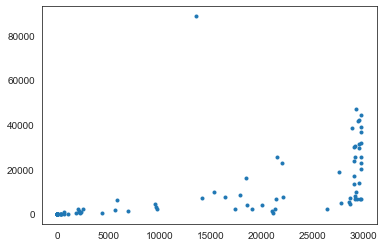

In [73]:
plt.plot(genomes.assembly_length_unambiguous, genomes.assembly_mean_coverage,'.')
stats.spearmanr(genomes.assembly_length_unambiguous, genomes.assembly_mean_coverage)

# Synthetic comparisons

## Set up data tables

In [58]:
# elution time
elution_time = elution.copy()
elution_time['Type'] = elution_time['Category'].str.split(pat='(-)',expand=True).iloc[:,2]
elution_time['Time'] = elution_time['Category'].str.split(pat='(-)',expand=True).iloc[:,0]
elution_time['Ct Mean'] = pd.to_numeric(elution_time['Ct Mean'], errors='coerce').replace(np.nan,40)
elution_time.rename(columns={'Time':'variable','Ct Mean':'value'}, inplace=True)

In [59]:
# elution buffer
buffer_order = ['AVL','LB','0.5LB','VTM','TE'] # translating from samples s## to what the buffer was
buffer_df = PCR_results(buffer)
buffer_df = buffer_df[buffer_df['Sample Name'].str.startswith(('s','H2O'))].rename(columns={'CT':'value'})
buffer_df['variable'] = ['Water Control' if s=='H2O' else \
                         buffer_order[int(np.floor((int(s[1:])-1)/3))] for s in buffer_df['Sample Name']]

In [60]:
# rotating or not rotating -- some data points will be for box and whisker, and some just for scatter plots
rotation_df = PCR_results(rotation)
rot_dict = {"1hr: Rotation": rotation_df[rotation_df['Sample Name'].str.contains('HR')]['CT'].values,
            "10m: Rotation": rotation_df[rotation_df['Sample Name'].str.contains('\d+R')]['CT'].values,
            "10m: No Rotation": rotation_df[rotation_df['Sample Name'].str.contains('\d+R')]['CT'].values}
rotation_box = pd.melt(pd.DataFrame.from_dict(rot_dict, orient='index').T)
rot_dict.update({"water":rotation_df[rotation_df['Sample Name'].str.contains('H2O')].CT.values,
                 "viral seedstock":rotation_df[rotation_df['Sample Name'].str.contains('POS')].CT.values})
rotation_dot = pd.melt(pd.DataFrame.from_dict(rot_dict, orient='index').T).dropna()

In [61]:
# affect of time difference between seeding & extraction
seeding_sample = PCR_results(seeding)
seeding_sample['Type'] = seeding_sample['Sample Name'].str.split(pat='(_)',expand=True).iloc[:,0]
seeding_sample['Day'] = pd.to_numeric([t[-1] for t in seeding_sample.Type], errors='coerce')
seeding_sample['variable'] = seeding_sample['Sample Name'].str.split(pat='(_)',expand=True).iloc[:,2]
seeding_sample['variable'] = ['Strip' if n in ['1','2','3'] else n for n in seeding_sample.variable]
seeding_sample['variable'] = ['Seedstock' if n in ['pos'] else n for n in seeding_sample.variable]
seeding_sample = seeding_sample[[x is not None for x in seeding_sample.variable]]

In [62]:
#Kingfisher v. Column extractions
kff = PCR_results(KFFcomp).rename(columns={'CT':'value'})
kff[['variable','details']] = kff['Sample Name'].str.split(pat='(_)',expand=True)[[0,2]]
kff = kff[[d is not None for d in kff.details]].reset_index(drop=True)
for nonsample in ['H2O','Stock']:
    kff.loc[kff.details==nonsample,'variable'] = nonsample

## Box and whisker plots

In [63]:
sns.set_style("white")

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

24h vs. 1h: p=0.11
1h vs. 10m: p=0.094
24h vs. 10m: p=0.74


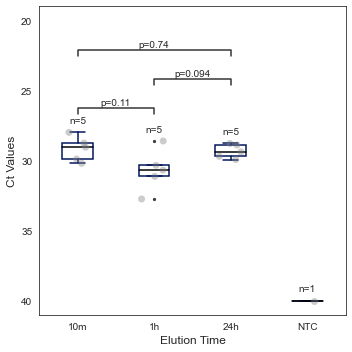

In [64]:
df = elution_time[(elution_time.Type!='tube') & (elution_time.Type!='PosCtrl')]
order = ['10m','1h','24h','NTC']

f, ax = plt.subplots(1,1,figsize=[5,5])
sns.stripplot(data=df, x="variable", y="value", order=order, **args_stripplot)
sns.boxplot(x="variable", y="value", data=df, order=order, **args_boxplot)
add_n_XX(df,'variable','value',order,ax,offset=.65,max=False)

ax.set_ylim([41,19])
plt.yticks(np.arange(20,45,5))

pairs = [['24h','1h'],['24h','10m'],['1h','10m']]
annotator = Annotator(ax, pairs,data=df,x='variable',y='value')
#annotator.set_pvalues(get_pvalues2(df,pairs))
pvalues = get_pvalues2(df,pairs)
annotator.set_custom_annotations([f'p={p:.2g}' for p in pvalues])
annotator.annotate()
df_wilcoxon = save_wilcoxon_variances('Elution Time', df, pairs, df_wilcoxon)

ax.set_xlabel('Elution Time', fontsize=12)
ax.set_ylabel('Ct Values', fontsize=12)
ax.get_legend().remove()

save_figure('fig/synthetic_elution_time.svg')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
<ipython-input-5-35075f165787>:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pvalues.append(stats.ttest_ind(a,b,equal_var=False).pvalue[0])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TE vs. AVL: p=0.34
AVL vs. VTM: p=0.079
AVL vs. LB: p=0.0029
AVL vs. 0.5LB: p=0.0029


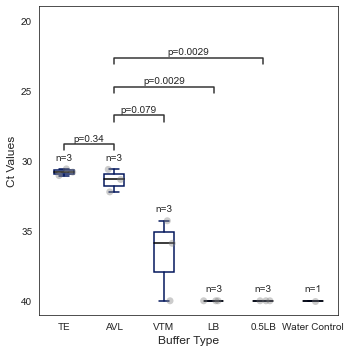

In [65]:
f = plt.figure(figsize=[5,5])

order = ['TE','AVL','VTM','LB','0.5LB','Water Control']
ax = sns.boxplot(x='variable',y='value',data=buffer_df,order=order,**args_boxplot)
sns.stripplot(data= buffer_df,order=order,x="variable", y="value",**args_stripplot)
add_n_XX(buffer_df,'variable','value',order,ax,offset=.65,max=False)

ax.set_ylim([41,19])
plt.yticks(np.arange(20,45,5))

pairs = [['TE','AVL'],['AVL','VTM'],['AVL','LB'],['AVL','0.5LB']]
annotator = Annotator(ax, pairs,data=buffer_df,order=order,x='variable',y='value')
#annotator.set_pvalues(get_pvalues2(buffer_df,pairs))
pvalues = get_pvalues2(buffer_df,pairs)
annotator.set_custom_annotations([f'p={p:.2g}' for p in pvalues])
annotator.annotate()
#df_wilcoxon = save_wilcoxon_variances('Buffer type', buffer_df, pairs, df_wilcoxon)

plt.xlabel("Buffer Type", fontweight='normal', fontsize=12)
plt.ylabel("Ct Values", fontweight='normal', fontsize=12) 
plt.legend([],[], frameon=False);

save_figure('fig/synthetic_buffer_type.svg')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10m: No Rotation vs. 10m: Rotation: p=1
10m: Rotation vs. 1hr: Rotation: p=0.77
10m: No Rotation vs. 1hr: Rotation: p=0.77


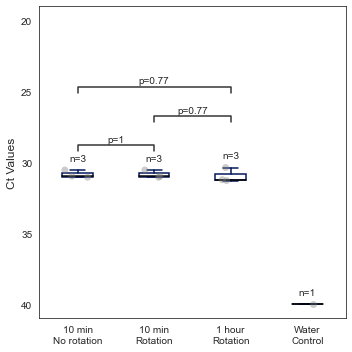

In [66]:
f = plt.figure(figsize=[5,5])
order = ['10m: No Rotation','10m: Rotation','1hr: Rotation','water']
ax = sns.boxplot(x='variable',y='value',data=rotation_dot,order=order,**args_boxplot)
sns.stripplot(data= rotation_dot,order=order,x="variable", y="value", **args_stripplot)
add_n_XX(rotation_dot,'variable','value',order,ax,offset=.65,max=False)

ax.set_ylim([41,19])
plt.yticks(np.arange(20,45,5))

pairs = [[order[0],order[1]],[order[0],order[2]],[order[1],order[2]]]
annotator = Annotator(ax, pairs, data=rotation_dot, order=order, x='variable', y='value')
#annotator.set_pvalues(get_pvalues2(rotation_dot,pairs))
pvalues = get_pvalues2(rotation_dot,pairs)
annotator.set_custom_annotations([f'p={p:.2g}' for p in pvalues])
annotator.annotate()
df_wilcoxon = save_wilcoxon_variances('Rotation', rotation_dot, pairs, df_wilcoxon)

ax.set_xticklabels(['10 min\nNo rotation','10 min\nRotation','1 hour\nRotation','Water\nControl'])

plt.xlabel("Rotation", fontweight='normal', fontsize=12,visible=False)
plt.ylabel("Ct Values", fontweight='normal', fontsize=12)
plt.legend([],[], frameon=False);

save_figure('fig/synthetic_rotation.svg')

/Users/jsilbert/opt/miniconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ColumnExtract vs. KFFfromAVL: p=0.056
KFFfromAVL vs. KFFwithKFFBuffer: p=0.17
ColumnExtract vs. KFFwithKFFBuffer: p=0.013


<ipython-input-67-38564ba378da>:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ct_diff = (kff[kff.variable=='KFFfromAVL'].mean()+kff[kff.variable=='KFFwithKFFBuffer'].mean())/2


diff in ct: -2.040767166666665


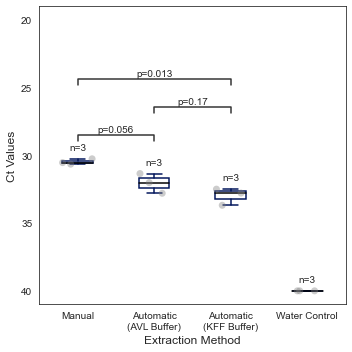

In [67]:
f = plt.figure(figsize=[5,5])
order = ['ColumnExtract','KFFfromAVL', 'KFFwithKFFBuffer','H2O']

ax = sns.stripplot(data=kff, x="variable", y="value", order=order, **args_stripplot)
sns.boxplot(x="variable", y="value", data=kff, order=order, **args_boxplot)
add_n_XX(kff,'variable','value',order,ax,offset=.65,max=False)

ax.set_ylim([41,19])
plt.yticks(np.arange(20,45,5))

pairs = [['ColumnExtract','KFFfromAVL'],['ColumnExtract','KFFwithKFFBuffer'],['KFFfromAVL','KFFwithKFFBuffer']]
annotator = Annotator(ax, pairs,data=kff,order=order,x='variable',y='value')
#annotator.set_pvalues(get_pvalues2(kff,pairs))
pvalues = get_pvalues2(kff,pairs)
annotator.set_custom_annotations([f'p={p:.2g}' for p in pvalues])
annotator.annotate()
df_wilcoxon = save_wilcoxon_variances('KFF', kff, pairs, df_wilcoxon)

ax.set_xlabel('Extraction Method', fontsize=12)
ax.set_xticklabels(['Manual','Automatic\n(AVL Buffer)','Automatic\n(KFF Buffer)','Water Control'])
ax.set_ylabel('Ct Values', fontsize=12)
ax.get_legend().remove()

ct_diff = (kff[kff.variable=='KFFfromAVL'].mean()+kff[kff.variable=='KFFwithKFFBuffer'].mean())/2
ct_diff = (kff[kff.variable=='ColumnExtract'].value.mean()-ct_diff).value
print('diff in ct:',ct_diff)

save_figure('fig/synthetic_extraction_method.svg')

## Linear regression

In [68]:
sns.set_style("white")

Linregress Results for Strips:
slope = -0.06 
CI = -0.23 to 0.10 
p = 0.4463694111099027

Linregress Results for Seedstock:
slope = 0.33 
CI = 0.07 to 0.58 
p = 0.047916512267600554



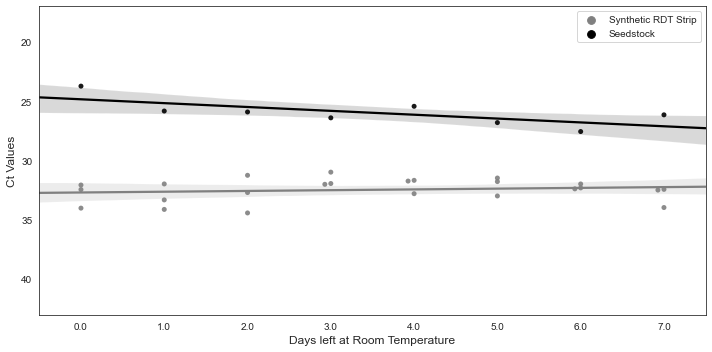

In [69]:
plt.figure(figsize=[10,5])

ax = sns.swarmplot(data=seeding_sample[seeding_sample.variable!='Ctrl'], x="Day", y="CT",**args_scatterplot_2x)
sns.regplot(x='Day', y= 'CT', data=seeding_sample[seeding_sample.variable=='Strip'],\
            scatter=False,truncate=False, line_kws = {'color':'grey'})
sns.regplot(x='Day', y= 'CT', data=seeding_sample[seeding_sample.variable=='Seedstock'],\
            scatter=False,truncate=False, line_kws = {'color':'black'})

ax.invert_yaxis()

plt.xlabel("Days left at Room Temperature", fontweight='normal', fontsize=12)
plt.ylabel("Ct Values", fontweight='normal', fontsize=12) 

ax.set_ylim([43,17])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=['Synthetic RDT Strip','Seedstock']);

#stats
slope95CI(seeding_sample[seeding_sample.variable=='Strip']['Day'],\
          seeding_sample[seeding_sample.variable=='Strip']['CT'],'Strips')
slope95CI(seeding_sample[seeding_sample.variable=='Seedstock']['Day'],\
          seeding_sample[seeding_sample.variable=='Seedstock']['CT'],'Seedstock')

save_figure('fig/synthetic_days_at_room_temp.svg')

# Wilcoxon variances

In [70]:
df_wilcoxon['F test statistic'] = df_wilcoxon['Variance (1)']**2 / df_wilcoxon['Variance (2)']**2
df_wilcoxon['F test statistic'] = [a if a>1 else 1/a for a in df_wilcoxon['F test statistic']]
df_wilcoxon['p value'] = [1-stats.f.cdf(df_wilcoxon['F test statistic'].loc[i], \
                                        df_wilcoxon['Group Size (1)'].loc[i]-1,\
                                        df_wilcoxon['Group Size (2)'].loc[i]-1) for i in range(len(df_wilcoxon))]
df_wilcoxon['Similar variances?'] = [p>.05 for p in df_wilcoxon['p value']]

In [71]:
df_wilcoxon

,Comparison,Group 1,Group Size (1),Variance (1),Group 2,Group Size (2),Variance (2),F test statistic,p value,Similar variances?
0,Ct Difference from PCR,iHealth,6,16.446366,Binax,9,11.706935,1.973574,0.187339,True
1,Ct Difference from PCR,iHealth,6,16.446366,Quickvue,8,19.207736,1.363994,0.341363,True
2,Ct Difference from PCR,Binax,9,11.706935,Quickvue,8,19.207736,2.691944,0.104789,True
3,Test Order,First,11,25.835558,Second,11,21.297348,1.471583,0.276253,True
4,Elution Time,24h,5,0.196841,1h,5,1.775235,81.335582,0.000439,False
5,Elution Time,24h,5,0.196841,10m,5,0.632499,10.324954,0.022014,False
6,Elution Time,1h,5,1.775235,10m,5,0.632499,7.877573,0.035207,False
7,Rotation,10m: No Rotation,3,0.049708,10m: Rotation,3,0.049708,1.000000,0.500000,True
8,Rotation,10m: No Rotation,3,0.049708,1hr: Rotation,3,0.174397,12.309037,0.075137,True
9,Rotation,10m: Rotation,3,0.049708,1hr: Rotation,3,0.174397,12.309037,0.075137,True


In [72]:
print(df_wilcoxon['Similar variances?'].sum(),'suitable for ranksums, out of',len(df_wilcoxon))

8 suitable for ranksums, out of 13
